In [1]:
!pip install flickrapi
import io
import os
import requests
import flickrapi
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
api_key = 'bb7ddb6a981cfb0bcee614f98fcdfe55'
api_secret = 'd21aaa4e2cb17221'
flickr = flickrapi.FlickrAPI(api_key, api_secret, format='parsed-json')
camera_models = ["Sony", "Canon", "Nikon"]
output_dir = './camera_dataset/train/'
metadata = []

for camera_model in camera_models:
    print(f"Downloading images for {camera_model}...")

    # 카메라 모델 이름에 따라 폴더 생성 (공백을 _로 변환)
    model_dir = os.path.join(output_dir, camera_model.replace(" ", "_"))
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Flickr API로 이미지 검색 (카메라 모델명으로 검색)
    photos = flickr.photos.search(text=camera_model, per_page=400, page=4, extras='url_o')
    for i, photo in enumerate(photos['photos']['photo']):
        photo_url = photo.get('url_o', None)
        if photo_url:
                # 이미지 다운로드
                response = requests.get(photo_url)
                file_path = os.path.join(model_dir, f'image_{i}.jpg')
                with open(file_path, 'wb') as f:
                    f.write(response.content)

                print(f"Downloaded {camera_model} image_{i}.jpg to {model_dir}")
                # 메타데이터 저장
                metadata.append({
                    'camera_brand': camera_model,
                    'file_name': f'image_{i}.jpg',
                    'file_path': file_path,
                    'url': photo_url
                })

metadata_df = pd.DataFrame(metadata)

# 브랜드별로 CSV 파일 저장
for brand in camera_models:
    brand_df = metadata_df[metadata_df['camera_brand'] == brand]
    csv_file = f'{brand}_data.csv'
    brand_df.to_csv(csv_file, index=False)
    print(f"Saved metadata for {brand} to {csv_file}")

Downloaded Sony image_0.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_1.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_2.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_5.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_8.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_9.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_10.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_18.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_19.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_22.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_23.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_24.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_25.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_26.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_27.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_29.jpg to ./camera_dataset/train/Sony
Downloaded Sony image_31.jpg to ./camera_datas

In [2]:
from PIL import Image
import os

def clean_dataset(dataset_path):
    for root, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # 이미지가 손상되었는지 확인
            except Exception as e:
                print(f"Removing invalid image: {file_path}, error: {e}")
                os.remove(file_path)

# 데이터셋 정리
clean_dataset('./camera_dataset/train/')

Removing invalid image: ./camera_dataset/train/Canon/image_253.jpg, error: cannot identify image file '/content/camera_dataset/train/Canon/image_253.jpg'
Removing invalid image: ./camera_dataset/train/Canon/image_137.jpg, error: cannot identify image file '/content/camera_dataset/train/Canon/image_137.jpg'
Removing invalid image: ./camera_dataset/train/Canon/image_108.jpg, error: cannot identify image file '/content/camera_dataset/train/Canon/image_108.jpg'
Removing invalid image: ./camera_dataset/train/Canon/image_182.jpg, error: cannot identify image file '/content/camera_dataset/train/Canon/image_182.jpg'
Removing invalid image: ./camera_dataset/train/Canon/image_144.jpg, error: cannot identify image file '/content/camera_dataset/train/Canon/image_144.jpg'
Removing invalid image: ./camera_dataset/train/Canon/image_124.jpg, error: cannot identify image file '/content/camera_dataset/train/Canon/image_124.jpg'
Removing invalid image: ./camera_dataset/train/Canon/image_53.jpg, error: ca

In [3]:
#데이터 전처리
transform = transforms.Compose([
     transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# ImageFolder로 전체 데이터셋 로드
full_dataset = datasets.ImageFolder('./camera_dataset/train/', transform=transform)

# 전체 데이터셋 인덱스 생성
dataset_size = len(full_dataset)
indices = list(range(dataset_size))

# 학습 데이터셋과 검증 데이터셋으로 80:20 비율로 분리
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# 학습 데이터셋과 검증 데이터셋 정의
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)

# 데이터 로더 생성
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# 클래스 확인 (카메라 모델 이름)
print(f"Classes: {full_dataset.classes}")

Classes: ['Canon', 'Nikon', 'Sony']


In [5]:
from torchvision.models import ResNet18_Weights
def customResnet(num_classes):
    # ResNet-18 모델 로드 (사전 학습된 가중치 사용)
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    # 출력 계층 수정 (클래스 수에 맞게)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

camera_models = ["Sony", "Canon", "Nikon"]

# GPU 또는 CPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 생성
model = customResnet(num_classes=len(camera_models))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.8MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

In [8]:
num_epochs = 10  # 학습할 에폭 수

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(num_epochs):
    model.train()  # 학습 모드

    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 이전 gradients 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # 검증 단계
    model.eval()  # 검증 모드
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * (correct / total)
    print(f"Validation Accuracy: {val_accuracy}%")

Epoch 1/10, Loss: 0.3908949928979079
Validation Accuracy: 77.22222222222223%
Epoch 2/10, Loss: 0.27996064846714336
Validation Accuracy: 83.88888888888889%
Epoch 3/10, Loss: 0.16045334904144207
Validation Accuracy: 83.88888888888889%
Epoch 4/10, Loss: 0.0662360879747818
Validation Accuracy: 84.44444444444444%
Epoch 5/10, Loss: 0.11944392664978902
Validation Accuracy: 86.66666666666667%
Epoch 6/10, Loss: 0.18113948746273914
Validation Accuracy: 82.22222222222221%
Epoch 7/10, Loss: 0.17142021687080464
Validation Accuracy: 86.11111111111111%
Epoch 8/10, Loss: 0.05357558544104298
Validation Accuracy: 86.66666666666667%
Epoch 9/10, Loss: 0.062083554066096745
Validation Accuracy: 86.11111111111111%
Epoch 10/10, Loss: 0.04735978624861067
Validation Accuracy: 88.88888888888889%


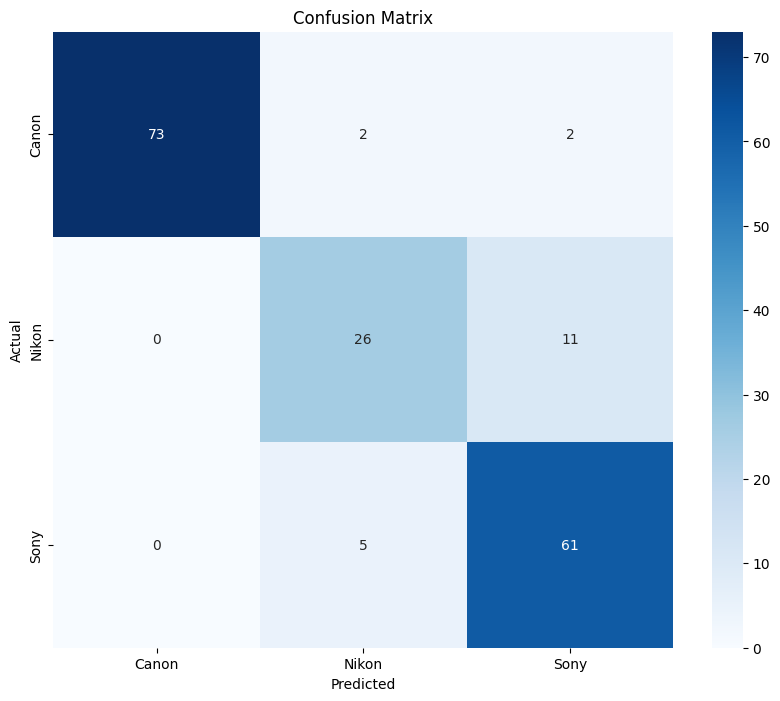

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 검증 단계 후, 혼동 행렬 계산
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from sklearn.metrics import classification_report

# F1 점수 및 정밀도, 재현율 출력
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

              precision    recall  f1-score   support

       Canon       1.00      0.95      0.97        77
       Nikon       0.79      0.70      0.74        37
        Sony       0.82      0.92      0.87        66

    accuracy                           0.89       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.89      0.89      0.89       180

